In [2]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))
# display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [5]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [6]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


In [7]:
from bktest.backtest_grid_search import *

tday = datetime.date.today()
roll_name = 'hot'
df, error_list = load_hist_data(
    start_date=datetime.date(2011,1,1),
    end_date=tday,
    roll_name=roll_name,
    sim_markets=all_markets,
    freq='d',
    shift_mode=2
)

if len(error_list) > 0:
    print(error_list)
    

In [ ]:
# field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

# start_date = datetime.date(2010,1,1)
# end_date = datetime.date(2023,1,20)
# shift_mode = 1
# roll_name = 'hot'
# roll_file_loc = "C:/dev/wtdev/config/"
# sim_markets = all_markets
# nb_cont = 2
# freq='d'

# data_df = pd.DataFrame()

# for prodcode in sim_markets:
#     for nb in range(nb_cont):
#         print("loading product = %s nb = %s" % (prodcode, nb))
#         xdf = dataseries.nearby(prodcode,
#                                   nb+1,
#                                   start_date=start_date, 
#                                   end_date=end_date, 
#                                   shift_mode=shift_mode,
#                                   freq=freq, 
#                                   roll_name=roll_name, 
#                                   config_loc=roll_file_loc)
#         xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
#         xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
#         xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
#         xdf['product'] = prodcode
#         xdf['code'] = f'c{nb+1}'
#         data_df = data_df.append(xdf)

# df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
# df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
# df.columns.rename(['product', 'code', 'field',], inplace = True)
# df.index = pd.to_datetime(df.index)

# print(df.tail(20))


In [8]:
#ind_metal_mkts
# scenarios = [('tscarry', 'ryield', 0.33, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'macdnma', 0.03, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
#              ('tsmom', 'macdnma', 0.03, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
#              ('tsmom', 'macdnma', 0.03, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
#              #('xsmom', 'mom', 0.0, 130, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'mom', 0.0, 230, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 60, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 10, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 40, 20, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'macdnma', 0.0, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 40, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 56, 280, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#             ] 

scenarios_test = [
    ('tscarry', 'ryieldnmb', 0.155, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0945, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0758, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0595, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0484, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.151, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.0844, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    #('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.22, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.502, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.420, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.527, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.163, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.147, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.143, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0406, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0381, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.0369, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.119, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.117, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.122, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.120, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.125, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.137, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 1.456, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'leader_lagger', 0.4, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]

scenarios_test2 = [
    ('tscarry', 'ryieldnmb', 0.1213, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.2727, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.0, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.184, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0103, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0532, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.1204, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.4054, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.3380, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    #('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.102, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.5282, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.1997, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.4554, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5546, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.0, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.4524, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.04414, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.1458, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.2731, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.1708, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.3562, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 1.1666, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'leader_lagger', 0.3989, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]

#commod_mkts
scenarios_elite = [ \
        ('tscarry', 'ryieldnmb', 1.0, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('xscarry', 'ryieldsma', 1.0, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldsma', 1.0, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'ryieldnma',1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry-rank_cutoff', 'ryieldnma', 1.0, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('xscarry', 'basmomsma', 1.0, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomsma', 1.0, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 1.0, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 1.0, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 1.0, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 1.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 1.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#        #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 1.0, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 1.0, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('custom', 'hc_rb_diff', 1.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
        #('custom', 'hc_rb_diff', 0.0767, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
        #('custom', 'hc_rb_diff', 0.0767, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
        ('custom', 'leader_lagger', 0.4, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]


scenarios_elite_new = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
        ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('tsmom', 'macd', 0.09, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.07, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.04, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.025, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.18, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.216, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.255, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.4, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),                       
]


#commod_mkts
scenarios_all = [ \
             ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             #('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldsma', 0.15, 1, 110, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma',1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma', 1.8, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldnma', 0.2, 1, 210, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'hlbrk', 2.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.5, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('tsmom', 'momxma', 0.2, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'momxma', 0.15, 40, 80, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.375, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 30, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 220, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 40, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 110, 5, (misc.sign, {}, 'sign'), [0.0]), \
             ('tsmom', 'macdnma', 0.4, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
             ('tsmom', 'macdnma', 0.3, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
             ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
             #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 70, 60, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 100, 80, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 90, 10, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'macdnma', 0.1, 8, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 12.5], 0.2), \
             #('xsmom', 'macdnma', 0.1, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
             #('xsmom', 'macdnma', 0.1, 32, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 3.125], 0.2), \
             #('xsmom', 'macdnma', 0.1, 64, 100, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 1.56], 0.2), \
            ]

scenarios_mixed = [('tscarry', 'ryield', 3.0, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'macdnma', 1.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
                 ('tsmom', 'macdnma', 1.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
                 ('tsmom', 'macdnma', 1.0, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
                 #('xsmom', 'mom', 1.0, 130, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'mom', 1.0, 230, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 60, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 10, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 40, 20, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'macdnma', 1.0, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 40, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 56, 280, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), 
] 


scenarios_intraday = [ \
             #('xsfact', 'trdstrsma', 1.0, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xsfact', 'trdstrsma', 1.0, 1, 15, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 5, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 20, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
            ]

# scenarios_test = [
#     ('tsmom', 'macd', 1.0, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),
# ]




In [9]:
# bad
#     ('tsmom', 'basmomelv', 1.0, 230, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 110, 40, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('xsmom-rank', 'momqtl', 1.0, 60, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 120, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 240, 122, 1, (None, {}, ''), [0.0], 0.2),

# good
#     ('tsmom', 'macd', 1.0, 4, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 8, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 16, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 32, 1, 10, (None, {}, ''), [4, 35], 0.2),
    
# ?? 
# vs ryieldqtl
#     ('tscarry', 'ryieldelv', 1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 61, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),
# vs other basmomqtl
#     ('tscarry', 'basmomqtl', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 70, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 120, 244, 1, (None, {}, ''), [0.0, 0.0]),

# rank or demedian
#     ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

#     ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

#     ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

#     ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
#     ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
#     ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#     ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#     ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),


In [9]:
scen_names = {}
scen_metrics = {}
scen_stats = {}
bt_empirics = {}
holdings = {}

In [10]:
#holdings.keys()

dict_keys([])

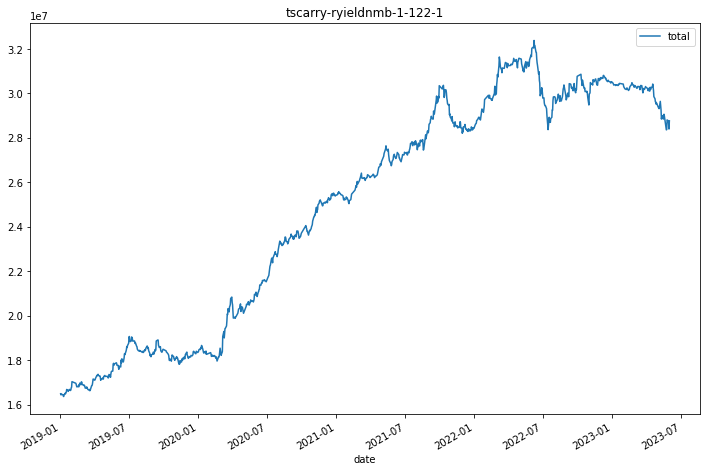

       sharpe        std  sortino
tenor                            
all      1.56   95662.39     2.24
6m      -2.17  114572.32    -3.08
1y      -1.16  162513.55    -1.82
2y       0.35  157953.89     0.56
3y       1.19  140300.52     1.84
4y       1.31  135298.59     2.04
5y       1.43  129432.40     2.23
6y       1.40  120889.19     2.14
7y       1.57  116486.50     2.42
8y       1.50  113123.55     2.29
9y       1.48  108502.14     2.24
10y      1.54  104291.30     2.29
11y      1.62  100900.17     2.40


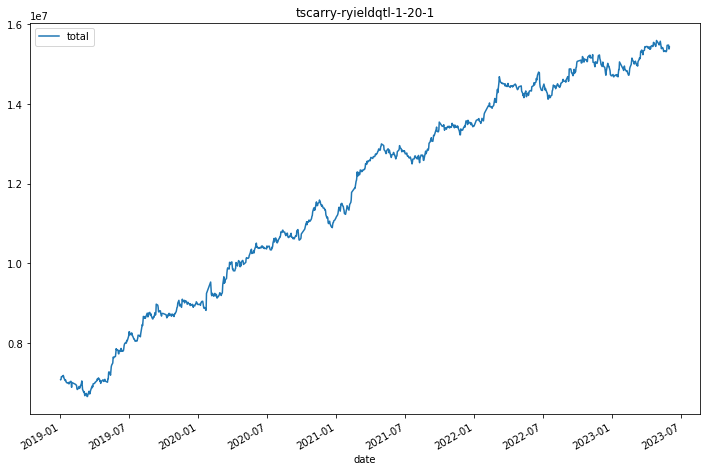

       sharpe       std  sortino
tenor                           
all      1.59  50180.71     2.55
6m       0.68  61097.20     1.22
1y       1.09  63554.78     1.74
2y       1.43  60386.58     2.35
3y       1.87  58200.09     3.10
4y       2.02  60390.94     3.54
5y       1.92  59337.29     3.41
6y       1.65  57663.53     2.84
7y       1.70  56689.56     2.93
8y       1.53  56513.71     2.55
9y       1.54  55252.68     2.55
10y      1.65  53703.77     2.71
11y      1.64  52069.58     2.67


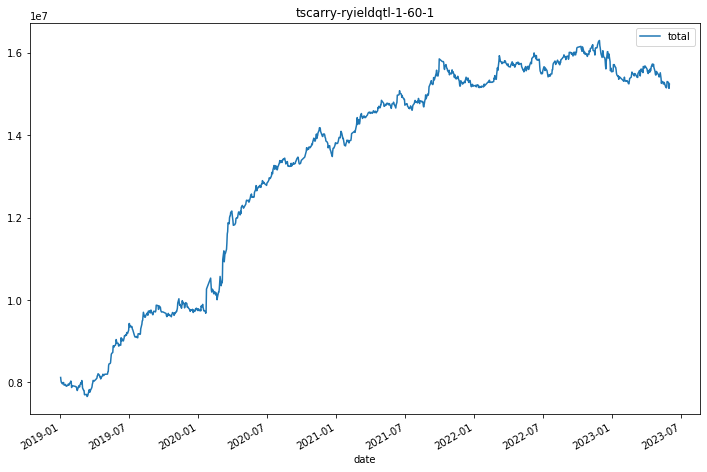

       sharpe       std  sortino
tenor                           
all      1.50  52673.74     2.37
6m      -1.56  73159.72    -2.61
1y      -0.51  65414.68    -0.83
2y       0.24  62359.51     0.42
3y       0.95  58874.46     1.61
4y       1.53  65922.44     2.76
5y       1.63  64109.97     2.85
6y       1.41  61179.88     2.41
7y       1.51  60103.44     2.58
8y       1.33  59207.32     2.20
9y       1.35  58177.67     2.20
10y      1.51  56502.61     2.45
11y      1.54  54751.19     2.48


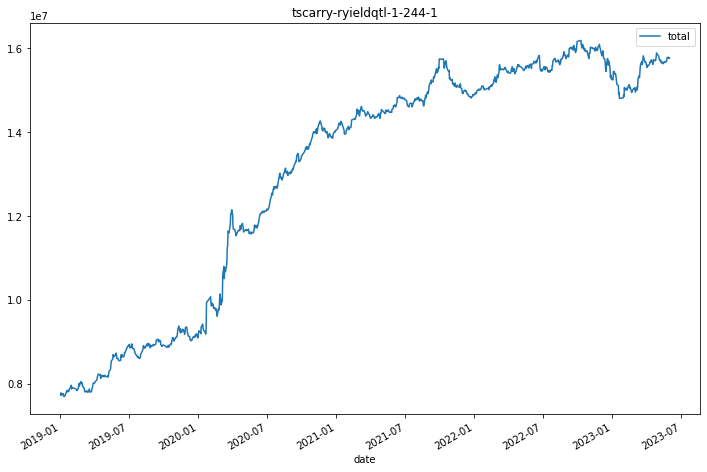

       sharpe       std  sortino
tenor                           
all      1.61  50634.62     2.43
6m      -0.41  74973.64    -0.63
1y       0.16  66743.79     0.25
2y       0.64  60326.39     0.99
3y       1.49  57022.03     2.29
4y       1.73  66636.17     2.83
5y       1.69  63994.41     2.73
6y       1.52  60457.53     2.44
7y       1.56  58829.52     2.51
8y       1.53  58134.81     2.41
9y       1.52  57149.06     2.41
10y      1.56  55178.72     2.47
11y      1.68  53551.64     2.64


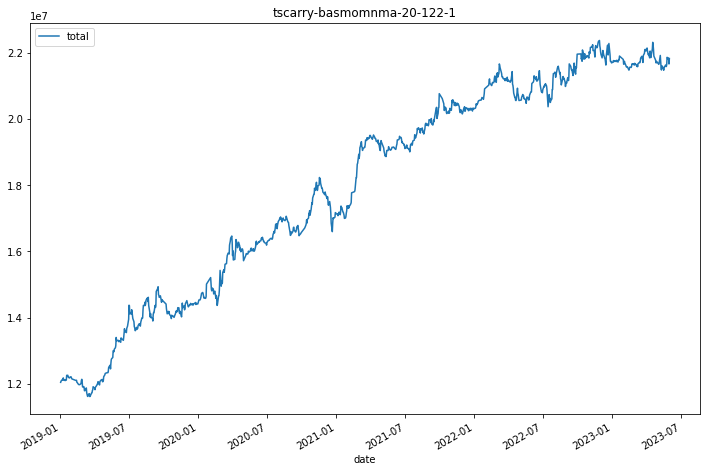

       sharpe        std  sortino
tenor                            
all      1.25   90185.65     1.82
6m      -0.39  105268.20    -0.61
1y       0.55  117458.49     0.95
2y       0.81  106048.16     1.35
3y       1.21  102516.91     1.98
4y       1.28  106677.46     2.03
5y       1.38  106089.94     2.20
6y       1.15  104210.38     1.79
7y       1.26  102270.39     1.97
8y       1.08  104572.41     1.66
9y       1.09  101199.59     1.67
10y      1.24   97303.94     1.87
11y      1.31   94245.46     1.95


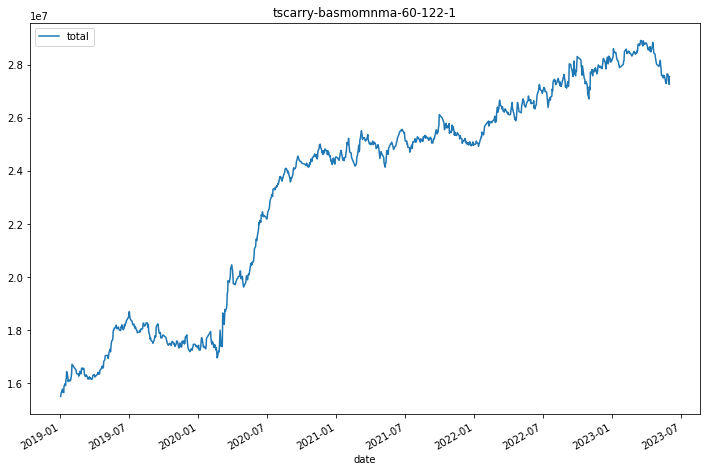

       sharpe        std  sortino
tenor                            
all      1.26  113784.21     1.89
6m      -0.45  115445.27    -0.86
1y       0.44  146690.02     0.83
2y       0.65  130587.02     1.17
3y       1.10  125641.83     1.95
4y       1.16  131310.31     2.03
5y       1.29  132489.35     2.10
6y       1.24  127216.54     2.00
7y       1.40  125142.76     2.28
8y       1.27  131013.68     2.03
9y       1.24  127310.43     1.96
10y      1.25  122661.31     1.96
11y      1.34  119616.91     2.09


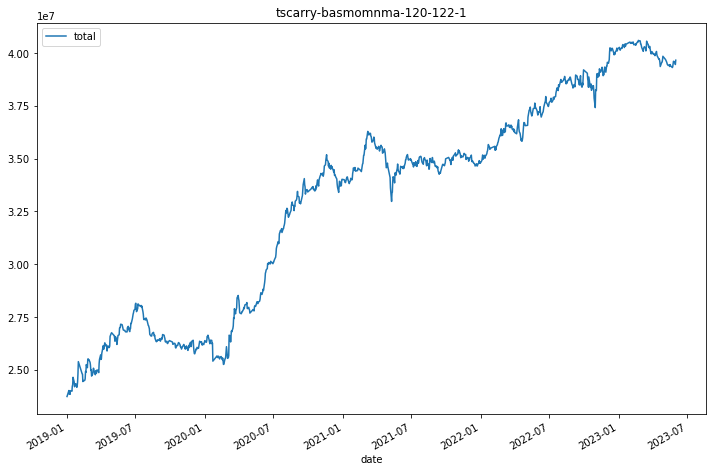

       sharpe        std  sortino
tenor                            
all      1.40  146698.45     2.06
6m       0.37   99754.21     0.67
1y       1.01  158129.85     1.66
2y       1.16  147885.47     1.97
3y       1.49  158331.98     2.33
4y       1.31  157077.92     1.97
5y       1.51  162056.59     2.31
6y       1.41  157861.75     2.16
7y       1.72  157059.85     2.70
8y       1.61  169498.98     2.50
9y       1.46  165549.14     2.28
10y      1.44  158828.49     2.22
11y      1.50  154904.78     2.29


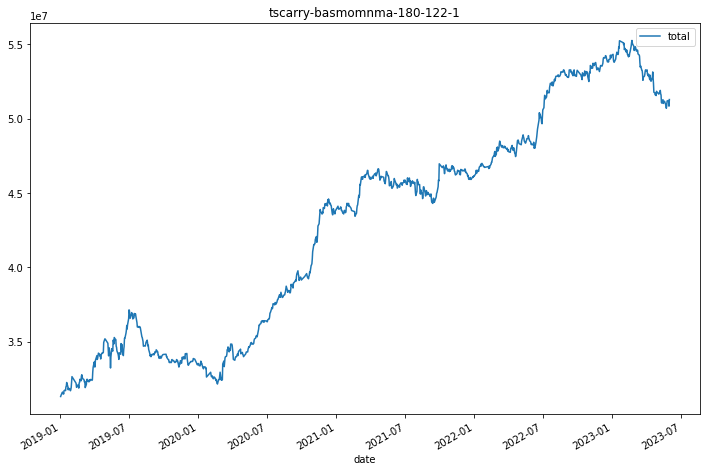

       sharpe        std  sortino
tenor                            
all      1.30  204596.79     1.88
6m      -1.32  212522.17    -2.06
1y       0.90  212095.78     1.46
2y       0.91  205855.68     1.61
3y       1.71  201395.48     2.91
4y       1.35  201705.18     2.25
5y       1.44  213659.34     2.39
6y       1.30  210336.10     2.08
7y       1.64  214324.96     2.69
8y       1.42  242780.95     2.24
9y       1.44  233384.75     2.25
10y      1.46  224052.89     2.24
11y      1.41  216805.17     2.15


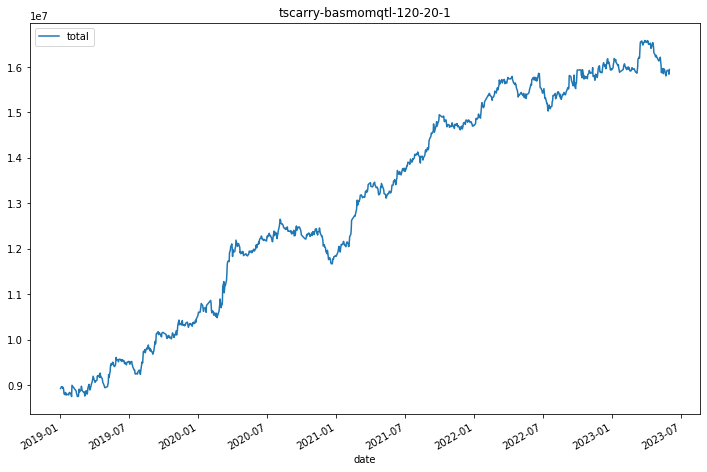

       sharpe       std  sortino
tenor                           
all      1.55  53380.97     2.53
6m       0.13  61171.91     0.21
1y       0.30  68990.35     0.47
2y       1.33  61378.59     2.15
3y       1.45  59013.51     2.36
4y       1.68  61103.24     2.76
5y       1.57  60167.20     2.63
6y       1.60  58500.83     2.66
7y       1.67  57371.23     2.78
8y       1.43  56876.24     2.37
9y       1.45  55865.84     2.38
10y      1.51  54329.63     2.47
11y      1.54  52735.05     2.51


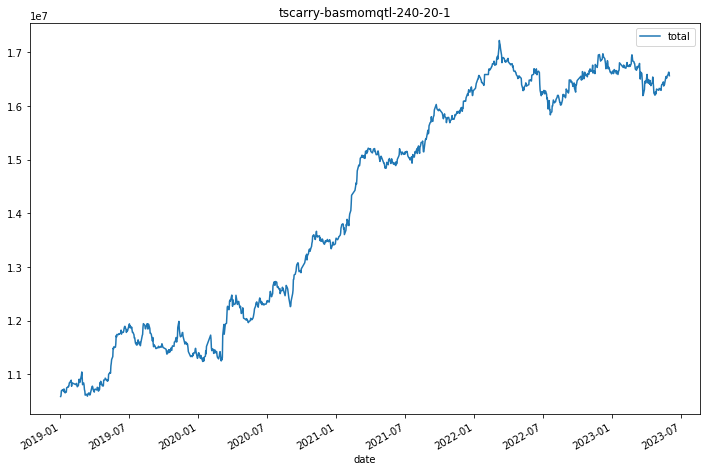

       sharpe       std  sortino
tenor                           
all      1.44  59650.94     2.34
6m      -0.66  63948.41    -1.00
1y       0.10  65955.48     0.15
2y       0.87  59963.77     1.33
3y       1.58  58685.32     2.51
4y       1.27  60973.30     2.07
5y       1.45  59156.78     2.40
6y       1.48  57299.50     2.42
7y       1.25  56178.20     2.06
8y       1.16  56370.56     1.85
9y       1.30  56469.37     2.09
10y      1.39  55129.38     2.23
11y      1.46  53950.84     2.35


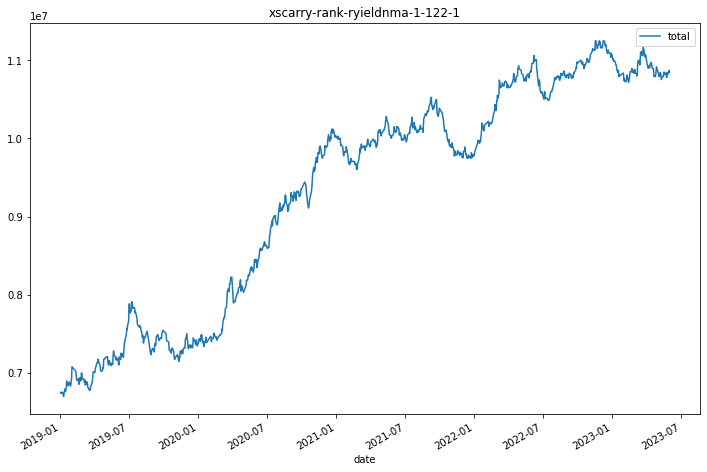

       sharpe       std  sortino
tenor                           
all      1.62  36261.10     2.54
6m      -1.23  40364.40    -1.95
1y      -0.01  39280.19    -0.01
2y       0.63  41095.49     0.94
3y       1.20  42944.99     1.92
4y       1.35  43932.65     2.21
5y       1.61  43513.97     2.71
6y       1.55  42353.78     2.59
7y       1.58  42015.78     2.66
8y       1.57  41280.80     2.62
9y       1.49  40028.32     2.47
10y      1.57  38945.65     2.58
11y      1.67  37533.07     2.68


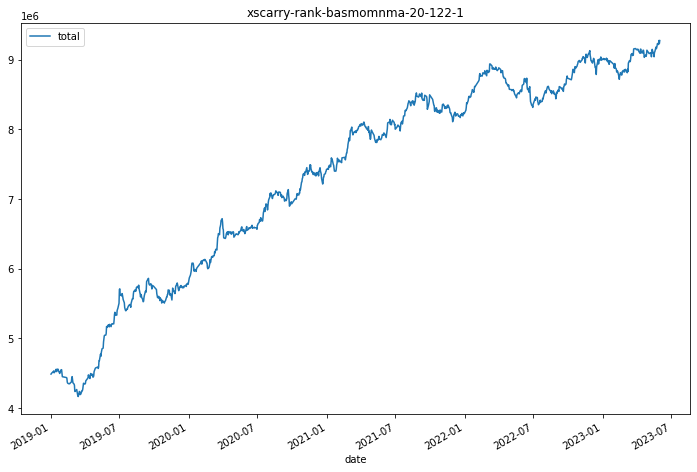

       sharpe       std  sortino
tenor                           
all      1.58  31921.66     2.44
6m       0.79  39383.34     1.36
1y       1.21  38495.66     1.89
2y       1.19  36653.41     1.88
3y       1.59  37202.07     2.52
4y       1.75  37666.26     2.82
5y       1.94  37458.19     3.12
6y       1.64  37414.09     2.61
7y       1.52  36952.70     2.45
8y       1.42  36130.96     2.27
9y       1.35  35052.59     2.15
10y      1.49  34032.71     2.36
11y      1.55  32810.82     2.42


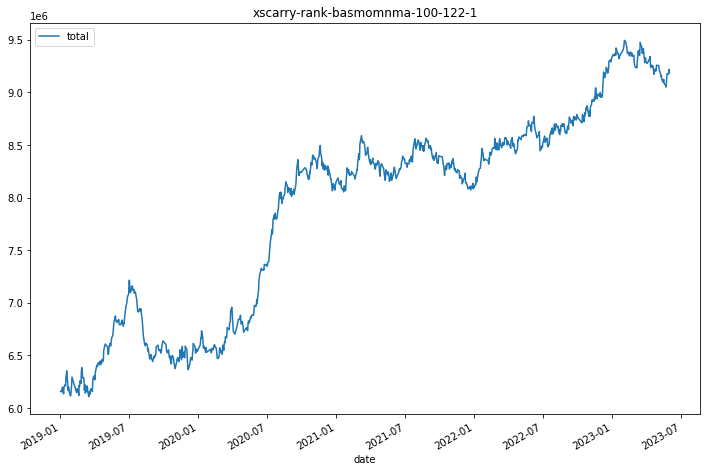

       sharpe       std  sortino
tenor                           
all      1.58  32522.81     2.51
6m       0.71  34254.24     1.24
1y       0.95  36553.74     1.60
2y       0.89  34974.22     1.49
3y       1.26  37507.80     2.11
4y       1.02  37252.83     1.70
5y       1.21  38778.81     1.97
6y       1.33  37904.92     2.16
7y       1.43  37456.66     2.37
8y       1.54  36718.75     2.54
9y       1.54  35444.40     2.53
10y      1.53  34313.98     2.49
11y      1.62  33102.98     2.59


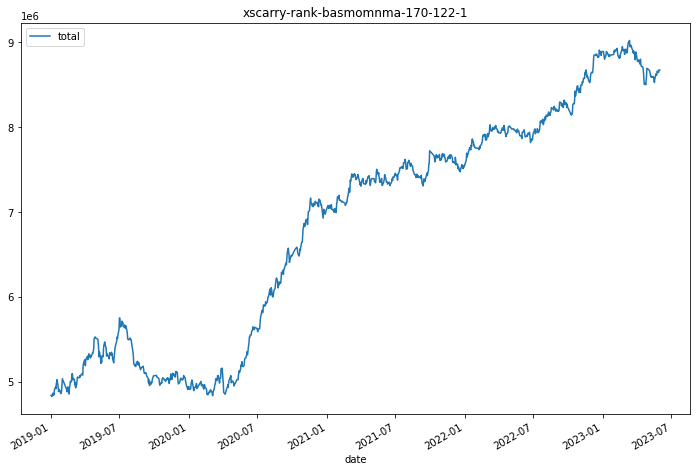

       sharpe       std  sortino
tenor                           
all      1.58  31573.10     2.50
6m       0.25  33879.72     0.41
1y       1.43  34891.73     2.44
2y       1.27  33430.77     2.23
3y       2.05  35514.83     3.53
4y       1.52  35571.10     2.58
5y       1.57  37458.67     2.58
6y       1.59  36173.02     2.59
7y       1.59  36064.28     2.62
8y       1.62  35247.38     2.64
9y       1.60  34006.18     2.59
10y      1.64  33016.32     2.64
11y      1.61  31814.66     2.55


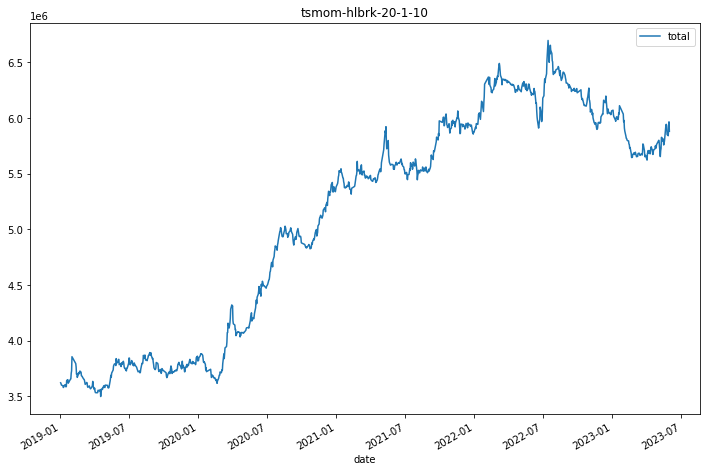

       sharpe       std  sortino
tenor                           
all      1.04  29427.72     1.50
6m      -0.29  38029.36    -0.39
1y      -0.53  41822.31    -0.72
2y       0.25  38455.24     0.37
3y       0.94  37092.61     1.38
4y       0.96  34826.72     1.40
5y       0.97  33201.98     1.42
6y       0.92  32358.58     1.36
7y       0.92  32275.58     1.38
8y       1.05  32986.38     1.55
9y       1.03  32173.59     1.53
10y      1.05  31151.61     1.54
11y      1.08  30364.43     1.58


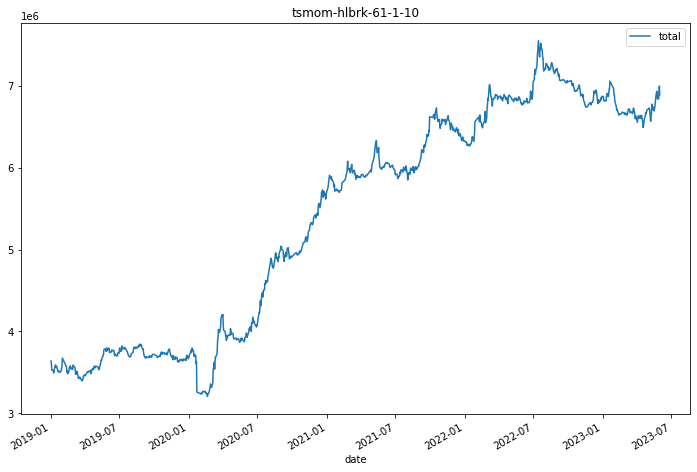

       sharpe       std  sortino
tenor                           
all      1.08  33043.24     1.51
6m       0.30  43511.56     0.39
1y       0.16  43175.59     0.21
2y       0.68  41788.43     1.03
3y       1.53  41430.27     2.34
4y       1.23  40997.62     1.65
5y       1.22  38632.26     1.66
6y       0.94  37145.22     1.31
7y       0.95  36502.98     1.34
8y       1.12  37230.04     1.58
9y       1.12  36232.70     1.59
10y      1.13  34939.52     1.58
11y      1.13  34139.72     1.58


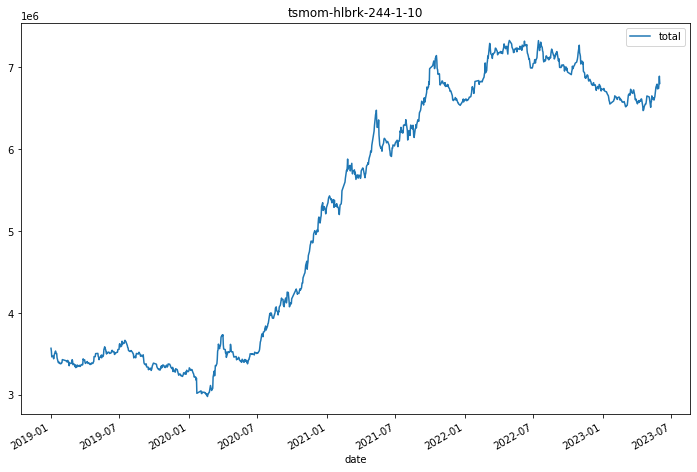

       sharpe       std  sortino
tenor                           
all      1.12  31561.67     1.54
6m      -0.12  31881.89    -0.18
1y      -0.79  35409.25    -1.14
2y       0.60  38924.00     0.92
3y       1.73  41655.64     2.61
4y       1.35  39173.19     1.97
5y       1.26  36453.47     1.82
6y       1.03  34401.13     1.48
7y       1.14  34597.99     1.68
8y       1.14  36161.46     1.67
9y       1.17  35231.02     1.70
10y      1.22  34119.37     1.76
11y      1.20  33298.44     1.73


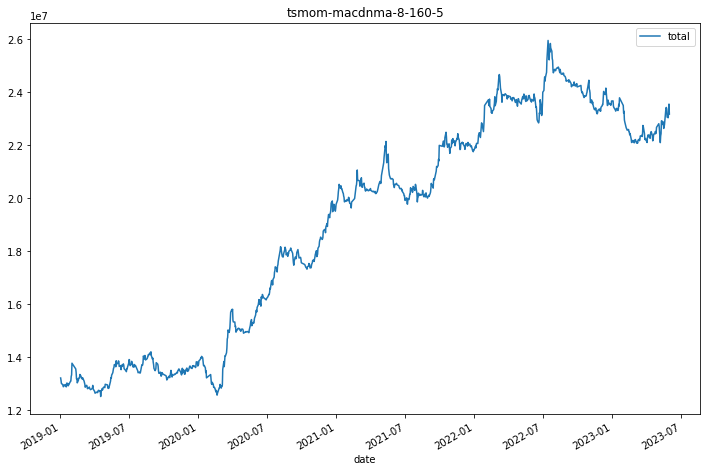

       sharpe        std  sortino
tenor                            
all      1.06  113552.10     1.51
6m      -0.13  162197.99    -0.16
1y      -0.19  168080.33    -0.26
2y       0.51  155118.79     0.76
3y       1.10  149627.15     1.60
4y       1.07  141024.13     1.57
5y       0.97  133172.16     1.43
6y       0.91  129066.58     1.35
7y       0.91  127630.80     1.38
8y       1.02  130437.57     1.52
9y       0.97  125645.44     1.44
10y      0.97  121073.74     1.43
11y      1.02  118190.90     1.49


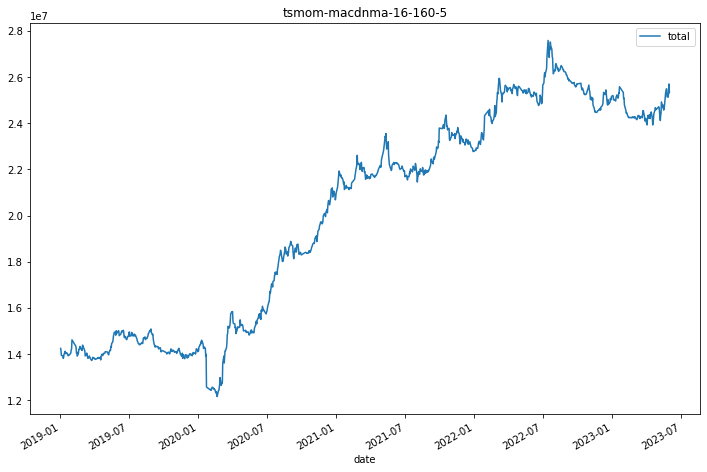

       sharpe        std  sortino
tenor                            
all      1.06  124279.21     1.44
6m       0.53  165018.14     0.71
1y       0.04  163423.18     0.05
2y       0.61  160595.21     0.92
3y       1.38  158385.36     2.04
4y       1.07  156657.02     1.42
5y       0.99  146898.35     1.33
6y       0.83  141509.87     1.15
7y       0.86  139930.21     1.21
8y       1.02  143160.13     1.44
9y       1.02  137721.31     1.44
10y      1.03  132403.89     1.43
11y      1.03  129503.30     1.43


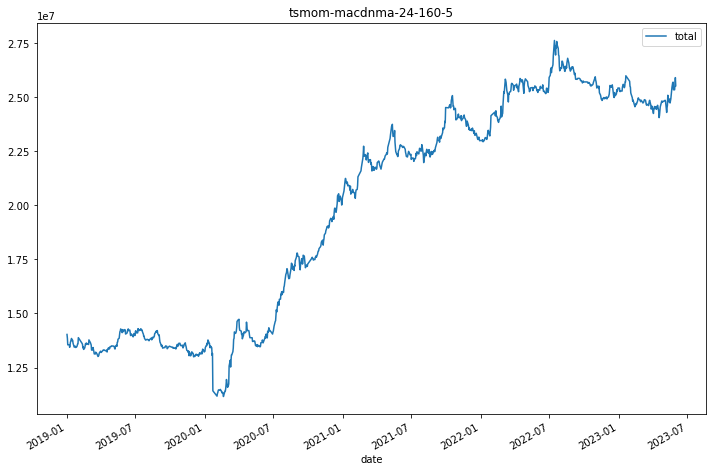

       sharpe        std  sortino
tenor                            
all      1.03  128616.39     1.36
6m       0.42  160771.57     0.58
1y       0.08  159382.48     0.11
2y       0.58  161511.92     0.86
3y       1.57  162497.04     2.36
4y       1.12  163623.29     1.43
5y       1.02  152866.85     1.32
6y       0.77  146418.55     1.02
7y       0.84  144808.94     1.14
8y       1.01  148030.59     1.38
9y       1.04  142645.41     1.42
10y      1.06  137110.45     1.43
11y      1.03  134020.65     1.40


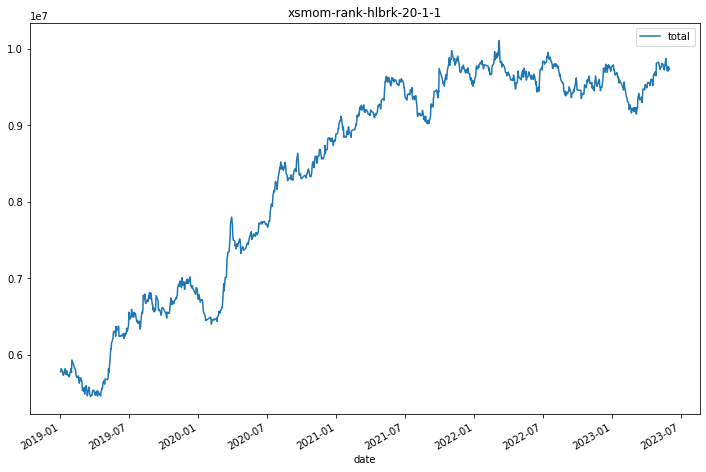

       sharpe       std  sortino
tenor                           
all      1.23  41215.42     1.97
6m       0.59  48962.11     1.09
1y       0.13  47380.33     0.21
2y       0.08  50365.81     0.13
3y       0.94  49345.10     1.55
4y       1.07  50949.27     1.80
5y       0.99  50484.97     1.68
6y       1.04  49272.53     1.76
7y       0.82  48041.25     1.38
8y       0.92  46869.64     1.54
9y       1.00  45798.88     1.66
10y      1.13  44464.11     1.86
11y      1.23  43022.46     2.00


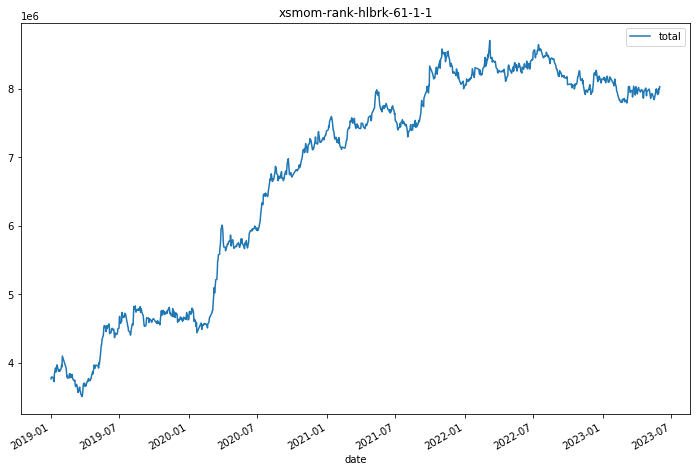

       sharpe       std  sortino
tenor                           
all      1.01  42063.52     1.58
6m       0.09  47573.02     0.14
1y      -0.31  44683.60    -0.48
2y       0.18  50412.25     0.30
3y       0.97  50165.38     1.60
4y       1.10  51353.24     1.85
5y       1.17  50888.14     1.95
6y       0.92  49821.56     1.51
7y       0.71  48394.22     1.16
8y       0.78  47214.66     1.27
9y       0.82  46281.11     1.33
10y      0.91  44961.84     1.46
11y      1.03  43583.08     1.63


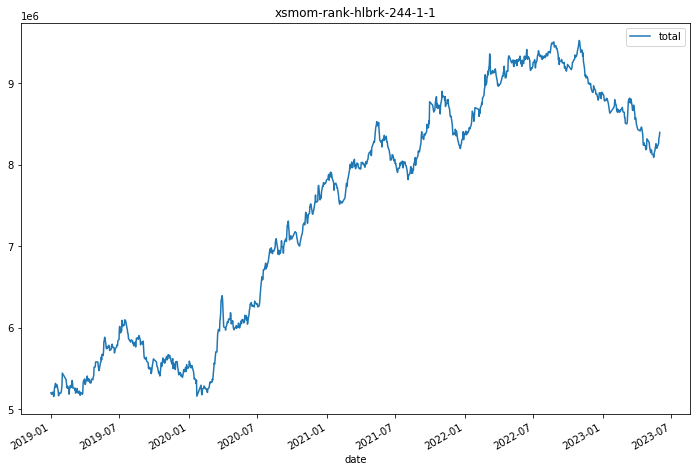

       sharpe       std  sortino
tenor                           
all      1.17  40465.93     1.78
6m      -1.85  41851.11    -3.10
1y      -1.37  40378.84    -2.10
2y       0.05  47973.58     0.08
3y       0.99  48495.84     1.63
4y       0.88  48400.48     1.43
5y       1.00  47628.82     1.63
6y       0.91  46105.43     1.45
7y       0.85  45541.56     1.35
8y       0.85  44769.48     1.34
9y       0.95  43651.63     1.49
10y      1.06  42244.74     1.64
11y      1.16  41006.47     1.78


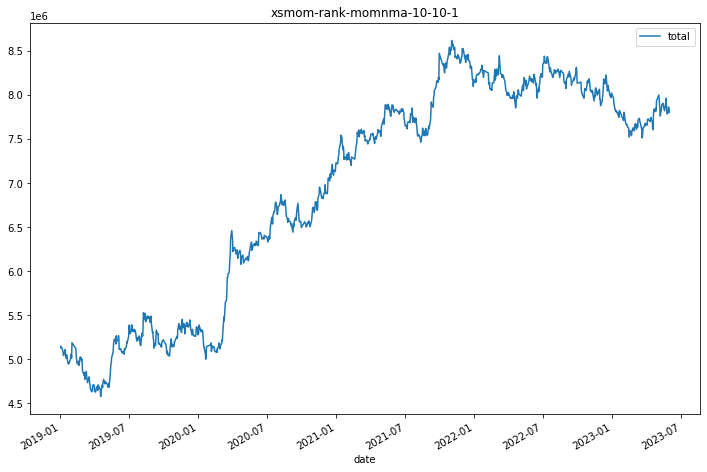

       sharpe       std  sortino
tenor                           
all      0.99  41114.45     1.59
6m      -0.34  50712.45    -0.49
1y      -0.48  48224.81    -0.71
2y      -0.04  50538.36    -0.06
3y       0.65  49682.74     1.03
4y       0.83  50716.23     1.35
5y       0.69  49968.43     1.15
6y       0.77  48785.18     1.28
7y       0.61  47469.77     1.02
8y       0.75  46652.07     1.25
9y       0.85  45614.32     1.40
10y      0.96  44178.22     1.58
11y      1.02  42821.69     1.66


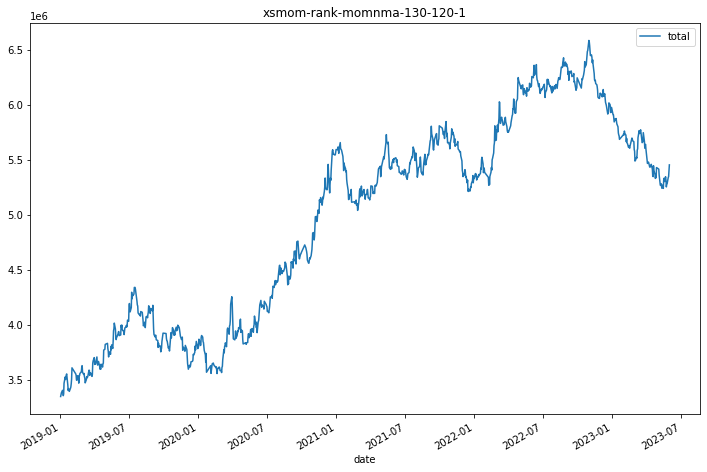

       sharpe       std  sortino
tenor                           
all      0.80  38664.14     1.20
6m      -2.06  40837.93    -3.39
1y      -1.13  40713.58    -1.81
2y      -0.04  45213.92    -0.05
3y       0.63  46825.44     1.01
4y       0.54  46441.75     0.85
5y       0.68  45430.51     1.07
6y       0.65  44119.13     1.01
7y       0.67  43676.81     1.05
8y       0.66  42950.87     1.03
9y       0.68  41634.78     1.06
10y      0.75  40247.30     1.15
11y      0.81  39169.11     1.24


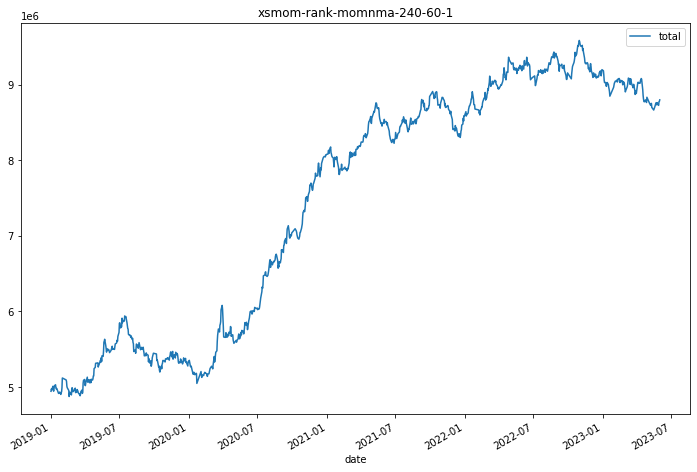

       sharpe       std  sortino
tenor                           
all      1.36  37216.84     2.14
6m      -1.61  38487.13    -2.52
1y      -0.69  40099.86    -1.06
2y       0.23  41369.98     0.36
3y       1.48  42728.75     2.38
4y       1.23  43378.76     1.94
5y       1.28  42708.20     2.08
6y       1.18  42022.53     1.91
7y       1.27  41427.80     2.06
8y       1.23  40834.80     1.99
9y       1.25  39602.54     2.00
10y      1.30  38317.71     2.06
11y      1.37  37393.34     2.15


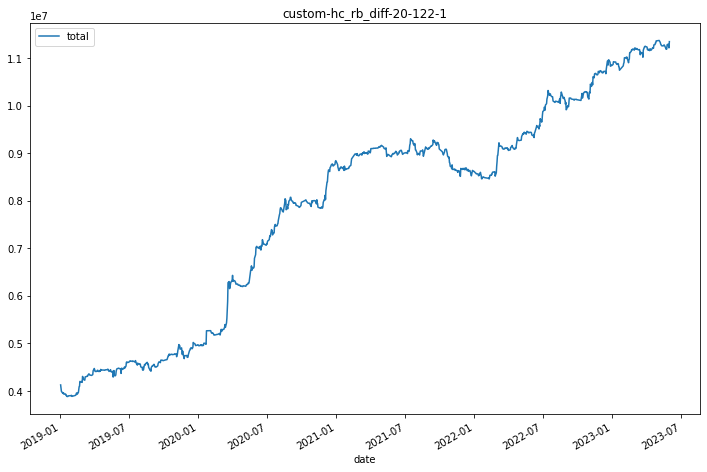

       sharpe       std  sortino
tenor                           
all      1.68  48728.07     2.69
6m       1.77  44539.82     3.37
1y       2.40  50620.25     4.39
2y       1.60  47154.35     2.93
3y       2.07  47057.36     3.66
4y       2.28  48574.11     4.10
5y       1.97  48377.50     3.28
6y       1.72  47136.84     2.83
7y       1.65  49122.55     2.63
8y       1.68  49898.71     2.74
9y       1.68  48728.07     2.69
10y      1.68  48728.07     2.69
11y      1.68  48728.07     2.69


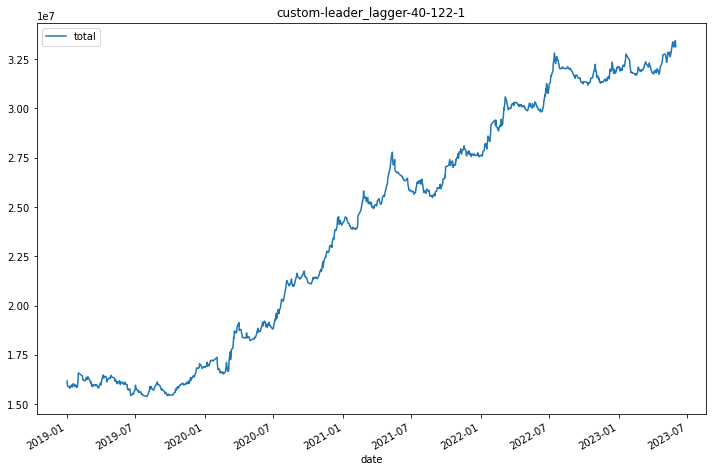

       sharpe        std  sortino
tenor                            
all      1.68  102181.48     2.42
6m       1.53  138393.93     2.19
1y       1.42  137550.13     2.04
2y       1.51  137843.97     2.36
3y       2.20  139396.60     3.46
4y       2.06  133439.27     3.14
5y       1.95  127003.72     3.00
6y       1.85  121618.15     2.85
7y       1.78  118250.42     2.74
8y       1.91  121233.29     2.90
9y       1.80  116367.79     2.72
10y      1.79  112044.65     2.66
11y      1.77  107618.37     2.59


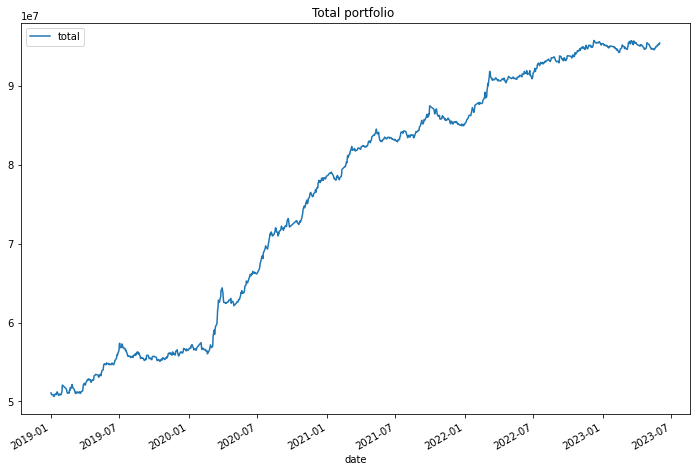

       sharpe        std  sortino
tenor                            
all      2.79  177004.03     4.72
6m       0.24  155408.43     0.47
1y       1.50  177982.61     2.58
2y       1.95  200576.68     3.44
3y       3.09  213175.24     5.54
4y       2.91  224391.63     5.25
5y       2.91  220646.78     5.26
6y       2.74  211648.66     4.85
7y       2.77  210237.21     4.96
8y       2.83  205958.93     5.05
9y       2.81  198732.44     4.97
10y      2.87  192409.13     4.99
11y      2.90  185921.84     4.96
pnl per trade: product
rb     43.512829
hc     74.800276
i     113.477051
j      72.254412
jm     47.409071
ru     27.840479
FG     40.370477
cu     11.349926
al     22.508750
zn     10.444952
sn     39.602392
l      19.208624
pp     40.264096
v      46.725758
TA     61.098773
sc    134.821204
m      18.020573
RM     10.795191
y      45.281862
p      56.947297
OI     37.612308
a       1.665060
c       1.783614
CF      9.583220
jd     21.752515
AP     99.113824
SM     30.101122
eb    21

In [9]:
file_folder = "C:\\dev\\data\\data_cache\\"

start_date = datetime.date(2011,1,1)
end_date = tday

scenario_map = {
    'test': scenarios_test,
    'test2': scenarios_test2,
    'elite': scenarios_elite,
}

shift_mode = 2
rev_char = '!'
exec_mode = 'open'
total_risk = 350_000.0
asset_scaling = False
std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'sn',
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd',
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni',]

# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

scenario_name = 'test2'

run_key = f'{roll_name}_{scenario_name}'
scenarios = scenario_map[scenario_name]

run_pos_sum = True
pos_sum = pd.DataFrame()
scen_names[run_key] = []
scen_metrics[run_key] = []
scen_stats[run_key] = []

port_start = pd.to_datetime('2019-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['total_risk'] = total_risk
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date    
    
    if (sim_type[:2] in ['ts', 'xs']):
        run_args['product_list'] = product_list
        run_args['rev_char'] = rev_char
        run_args['xs_signal'] = ''
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_name'] = signal_name
        run_args['win'] = win
        run_args['ma_win'] = ma_win
        run_args['rebal_freq'] = rebal
        run_args['params'] = params
        run_args['pos_map'] = pos_map
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_func'] = default_signal_gen
        if 'xs' in sim_type:
            sim_split = sim_type.split('-')
            if len(sim_split)>1:
                run_args['xs_signal'] = sim_split[1]
            else:
                run_args['xs_signal'] = 'rank_cutoff'    
        if len(scen) > 8:
            run_args['xs_params'] = {'cutoff': scen[8]}
    elif sim_type == 'custom':
        if signal_name == 'hc_rb_diff':
            run_args['product_list'] = [
                'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'UR',
                'cu', 'al', 'zn', 'ni', 'sn', 'ss',
            ]
            run_args['signal_func'] = hc_rb_diff
            run_args['win'] = win
        elif signal_name == 'leader_lagger':
            run_args['product_list'] = ['rb', 'hc', 'i', 'j', 'jm', 'SM', 'FG', 'v', 'UR', 'sc',
                                        'al', 'ni', 'sn', 'ss', 'TA', 'pp', 'eg', 'eb', 'p', 'y', 'OI',]
            run_args['conv_func'] = 'qtl'
            run_args['signal_func'] = leader_lagger    
    bt_metrics = run_backtest(df, run_args)
    scen_names[run_key].append(run_name)
    scen_metrics[run_key].append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
    scen_stats[run_key].append(pnl_stats)
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    #print('pnl per trade: %s, turnover: %s\n' % (pnl_stats['pnl_per_trade'], pnl_stats['turnover']))
    
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='pct', contract='c1')
df_pxchg = df_pxchg[product_list].reindex(index=pos_sum.index)

bt_met = MetricsBase(holdings=pos_sum, returns=df_pxchg)
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))
print('pnl per trade: %s, turnover: %s\n' % (port_stats['pnl_per_trade'], port_stats['turnover']))
bt_empirics[run_key] = bt_met

bt_metrics = bt_met

close_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='close')].droplevel([1, 2], axis=1)
close_prices = close_prices[product_list]
open_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='open')].droplevel([1, 2], axis=1)
open_prices = open_prices[product_list]
asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices, mode='ret')
port_pnl = asset_pnl.sum(axis=1).cumsum().to_frame('total')
holdings[run_key] = pos_sum[product_list].divide(close_prices[product_list])
print(port_pnl[-40:])
port_pnl.to_csv(file_folder + "port_pnl.csv")


In [11]:
#holdings[run_key]

product,rb,hc,i,j,jm,ru,FG,cu,al,zn,sn,l,pp,v,TA,sc,m,RM,y,p,OI,a,c,CF,jd,AP,SM,eb,eg,UR,ss,lu,lh,ni
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-07,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-10,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,-139.965516,-273.701884,1765.868645,-335.466003,-588.734539,-205.352348,123.397382,3.646364,143.656455,-74.316295,-3.679360,-4.423078,-419.143562,-842.998222,-32.046143,-1866.093651,440.322658,902.184494,-119.498598,90.388026,-112.639894,553.985369,198.981679,-64.404762,-454.835184,145.148948,221.972761,108.599111,-756.205834,-1400.174074,-22.466050,191.304079,-114.000387,3.250848
2023-05-25,-256.131974,-19.499016,1508.878368,-487.946173,-393.281119,-194.675240,471.233144,33.310810,190.672750,15.413565,-1.232156,-163.857056,-249.509388,-724.945075,-95.672129,-1180.217439,351.704493,723.734730,-159.328957,-11.668726,-125.641791,637.345276,225.881869,-59.225911,140.807104,102.872890,296.735107,93.045445,-769.491642,-1158.001669,52.705850,162.589809,-90.629510,8.041759
2023-05-26,-284.693279,92.721817,1597.549455,-563.228767,-620.116373,-219.733995,437.715546,45.626540,238.719073,77.245532,1.766533,-180.262884,-375.630486,-666.231145,-102.539131,-797.710961,210.200326,730.198689,-116.281191,-12.365035,-134.245091,585.416447,842.836128,-33.966884,-363.860840,117.957024,169.904829,189.981722,-848.290123,-1058.988413,156.155694,142.822325,-98.522878,9.998177


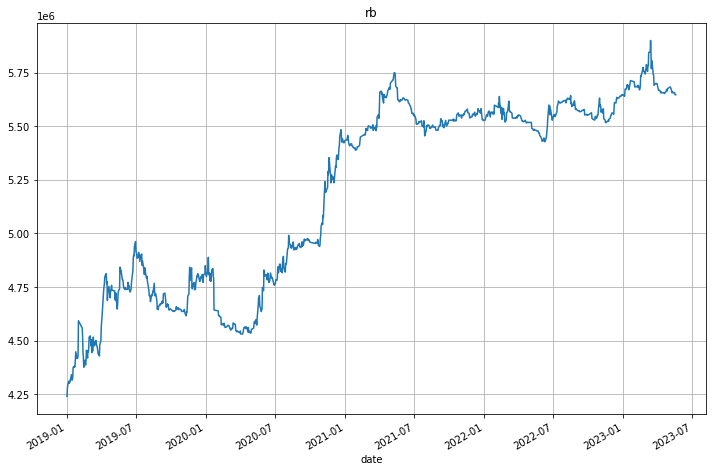

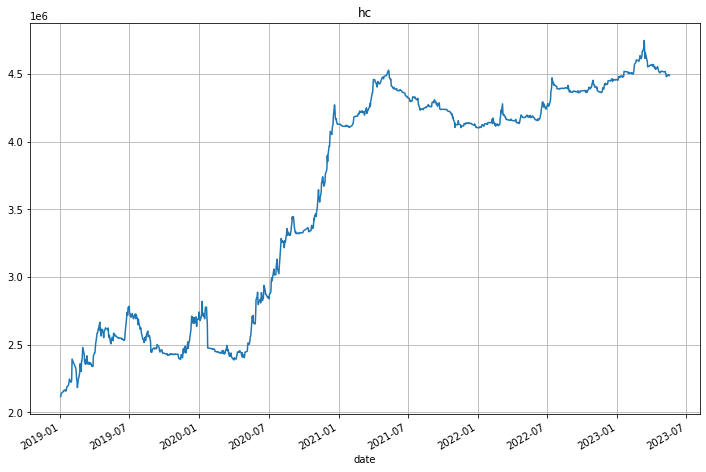

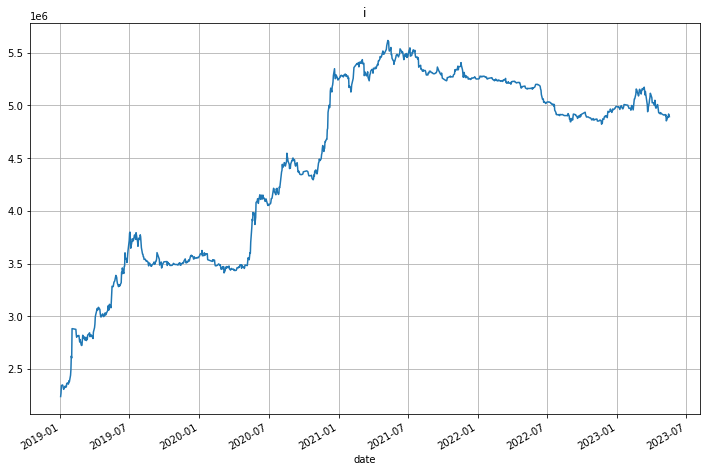

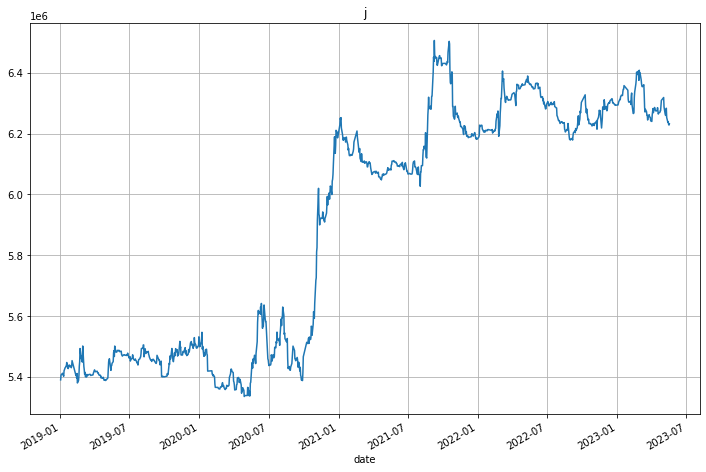

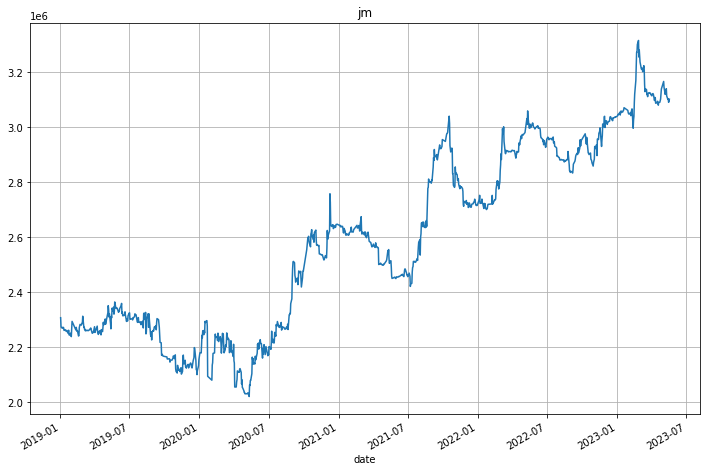

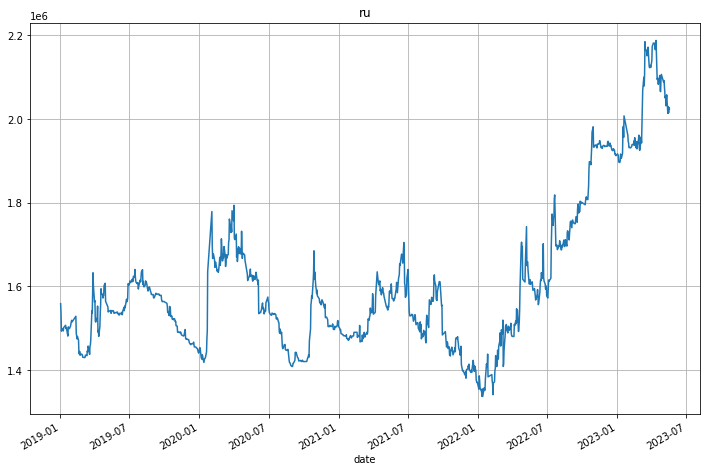

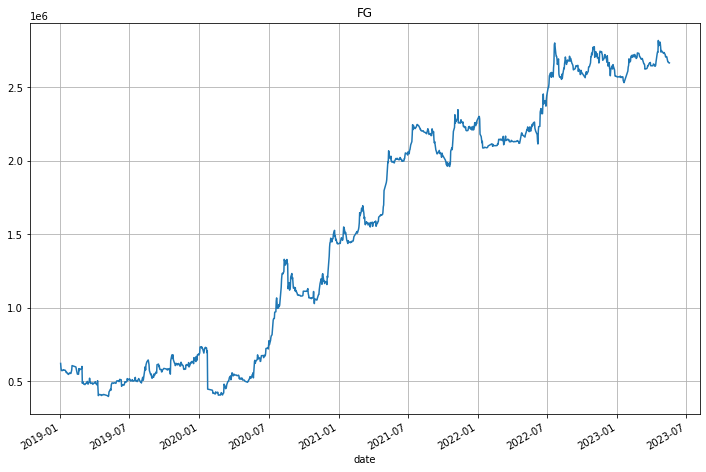

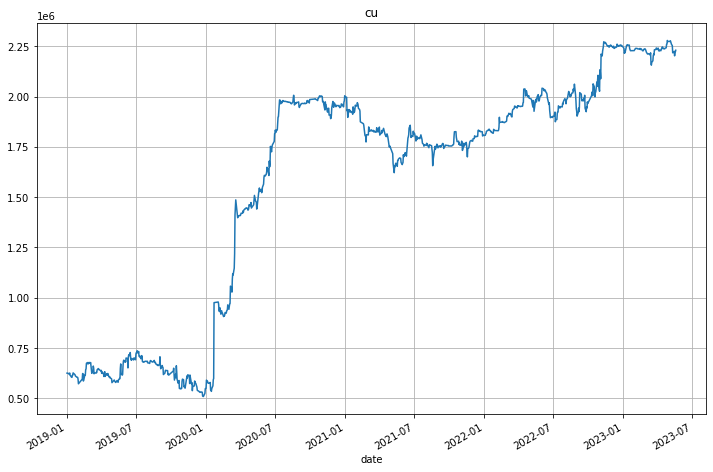

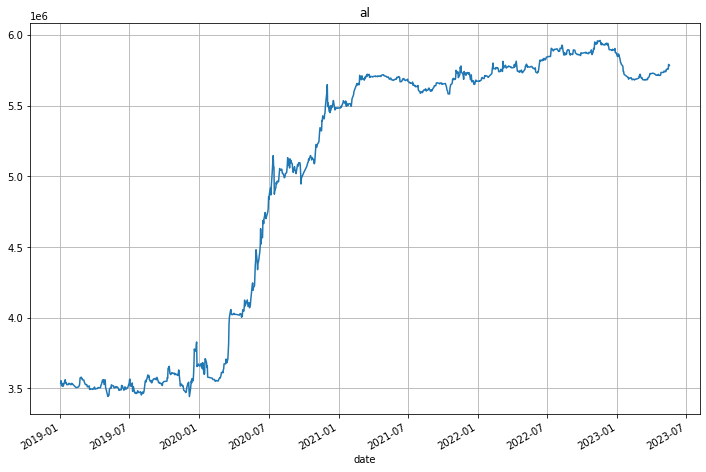

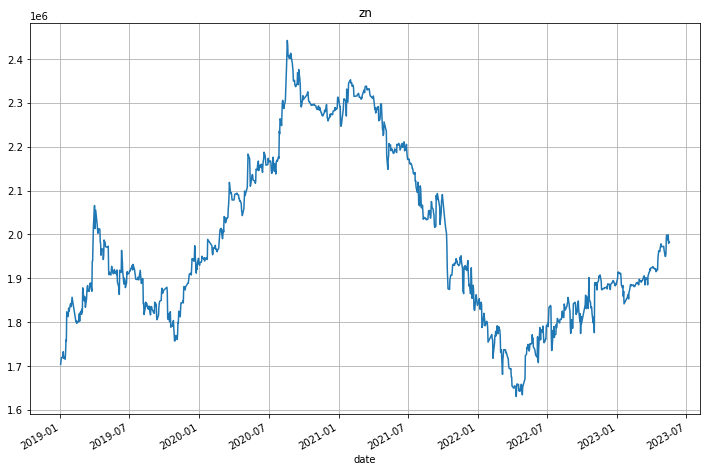

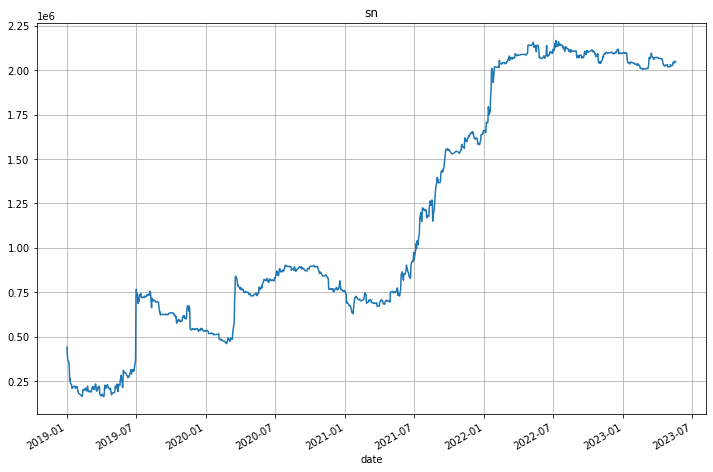

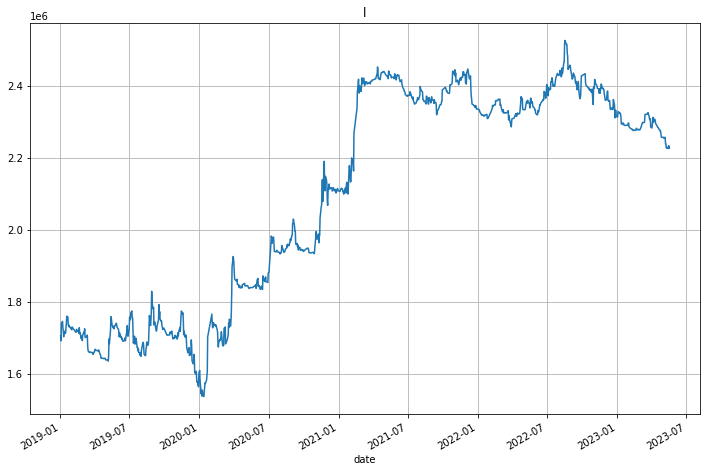

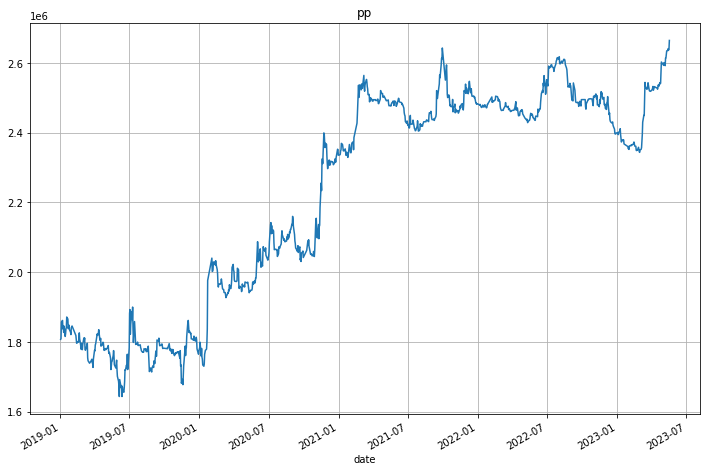

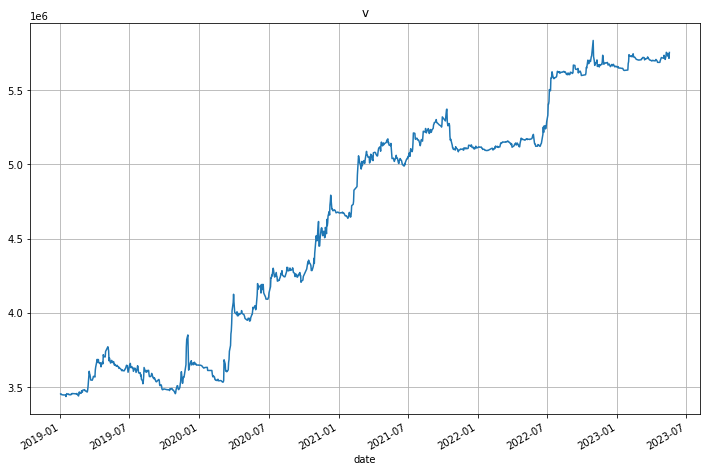

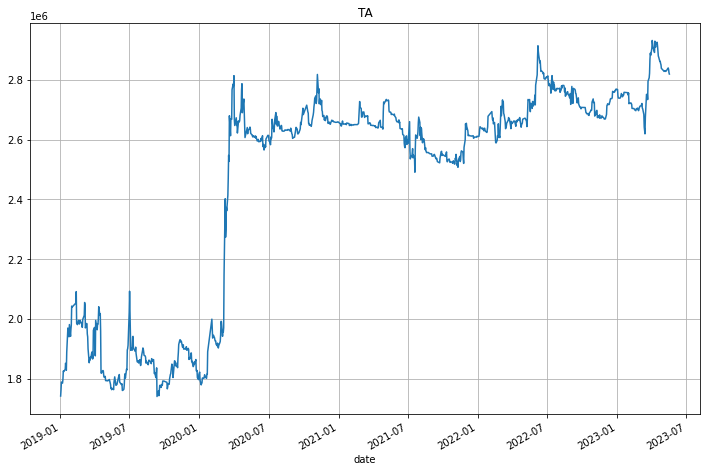

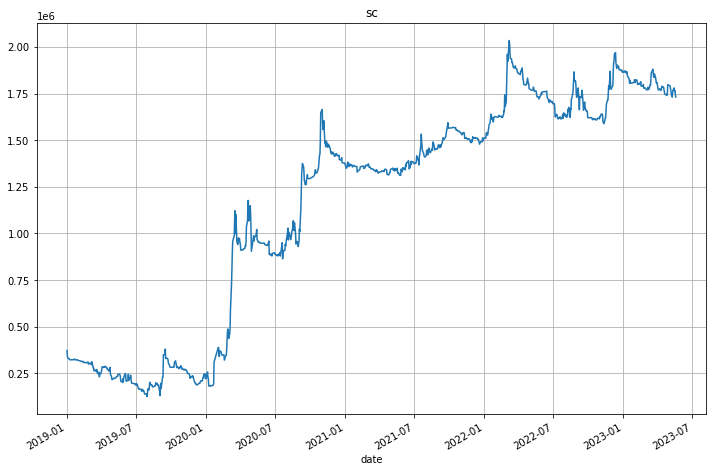

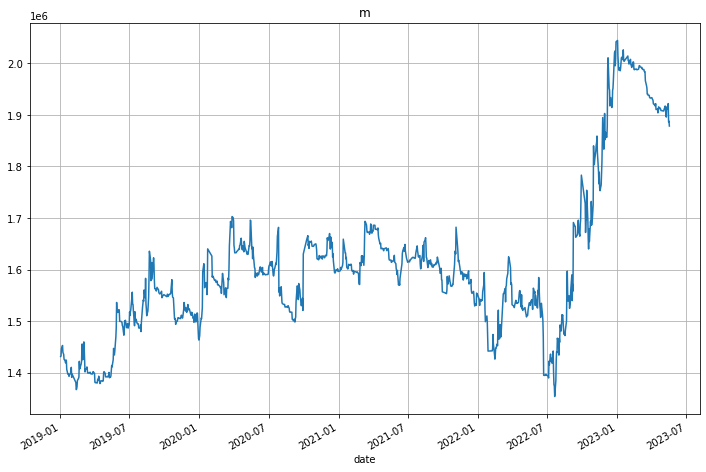

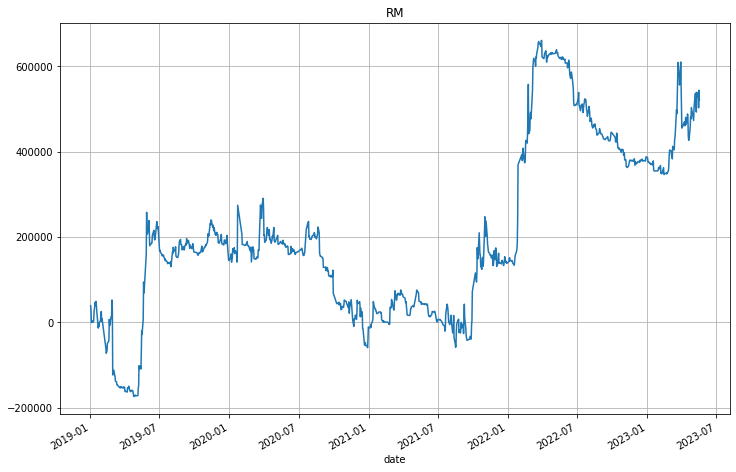

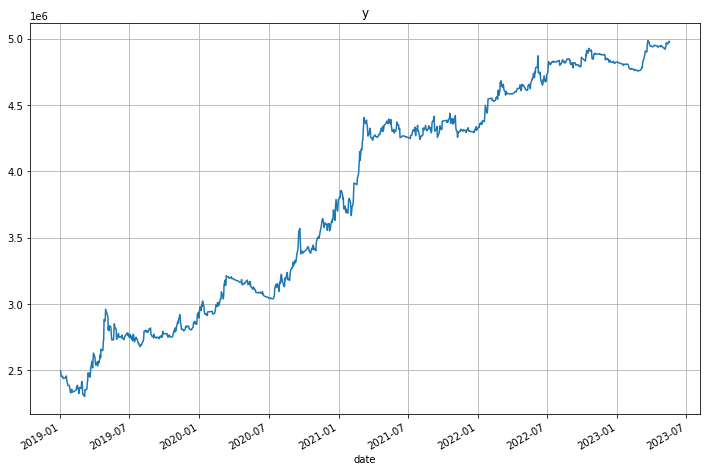

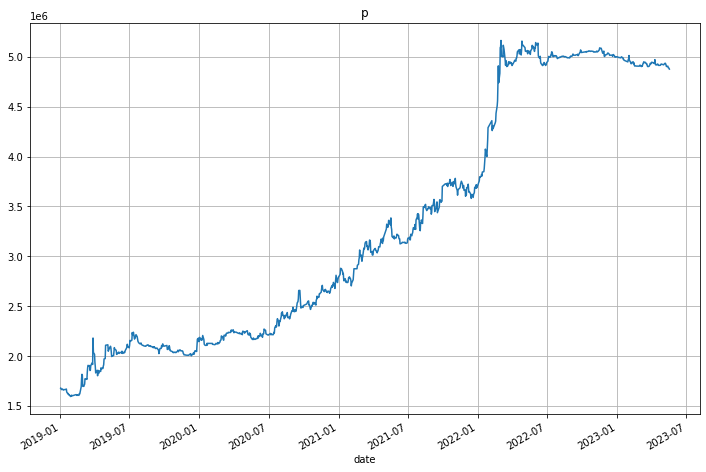

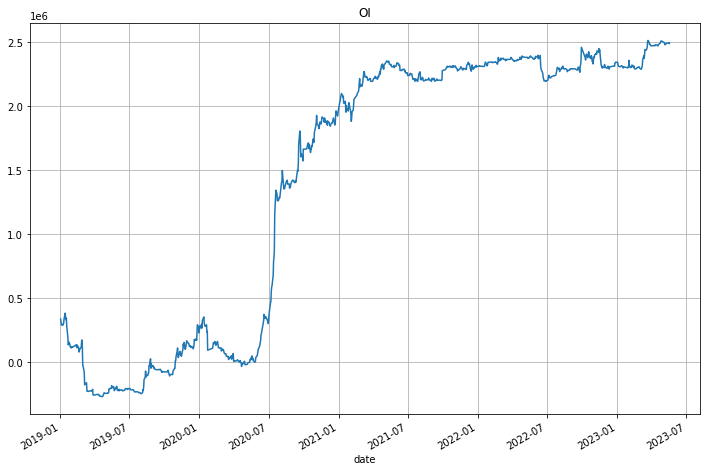

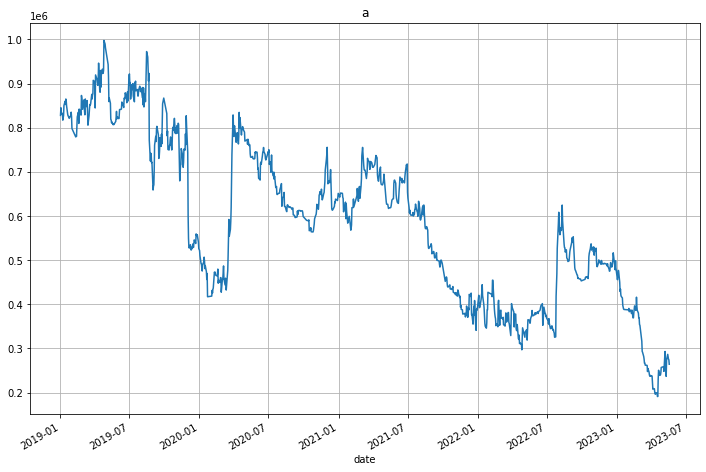

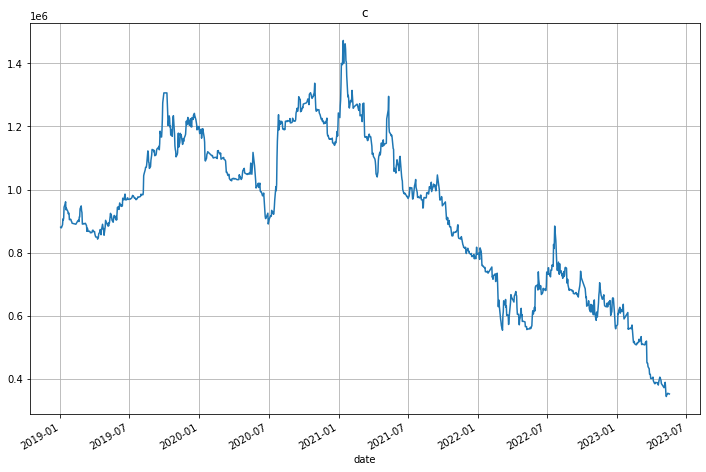

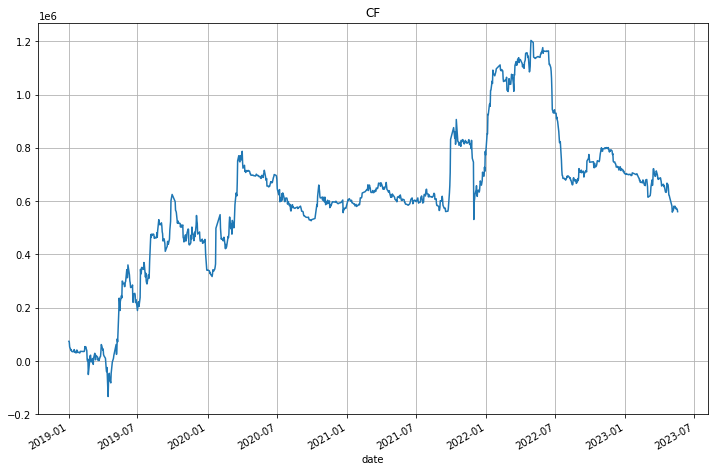

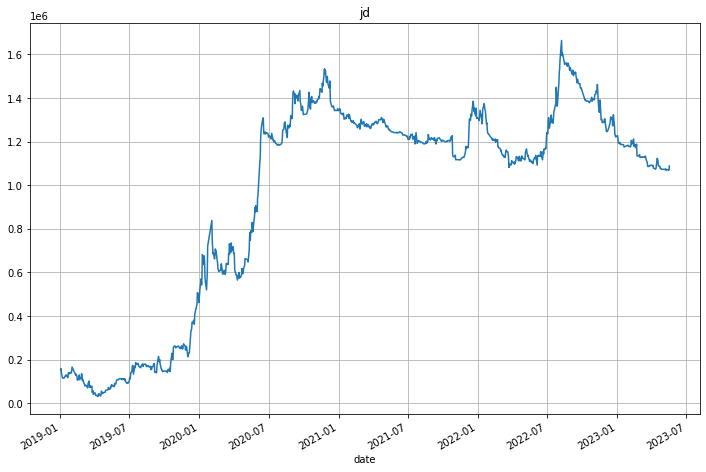

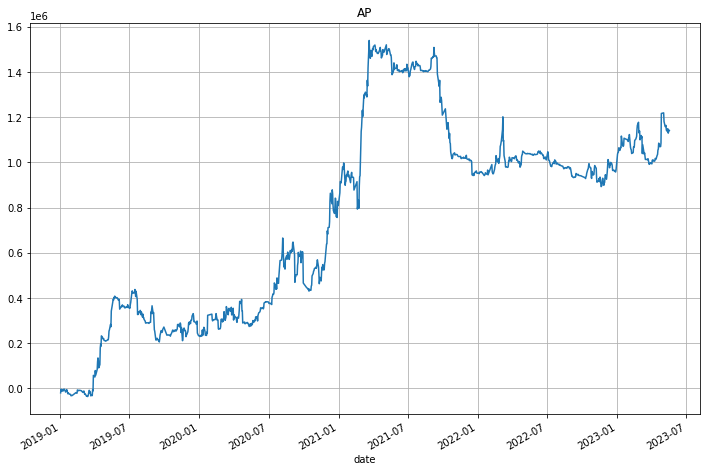

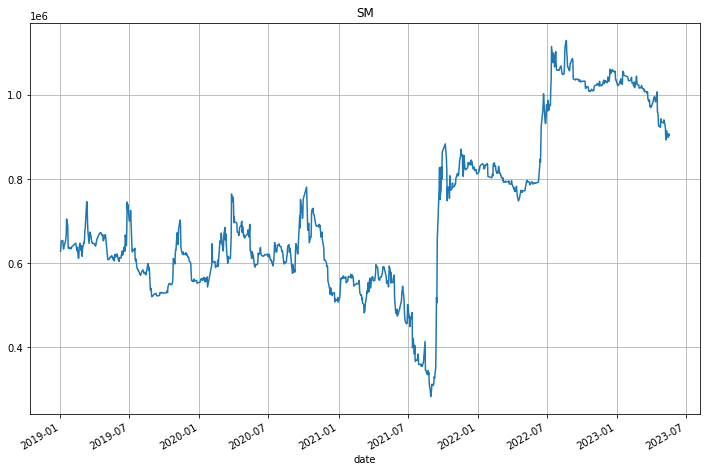

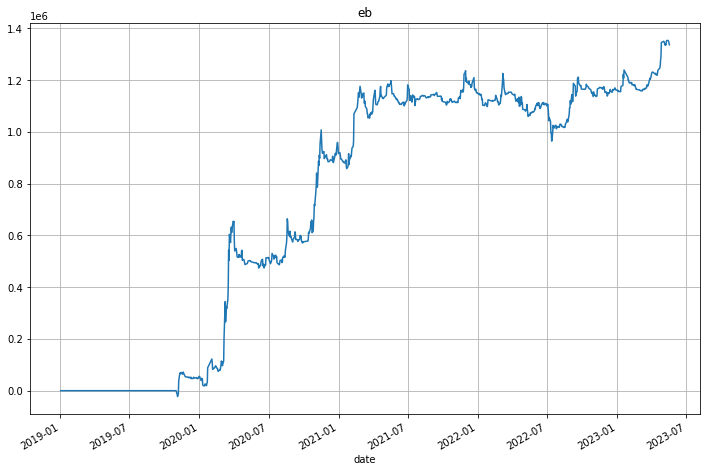

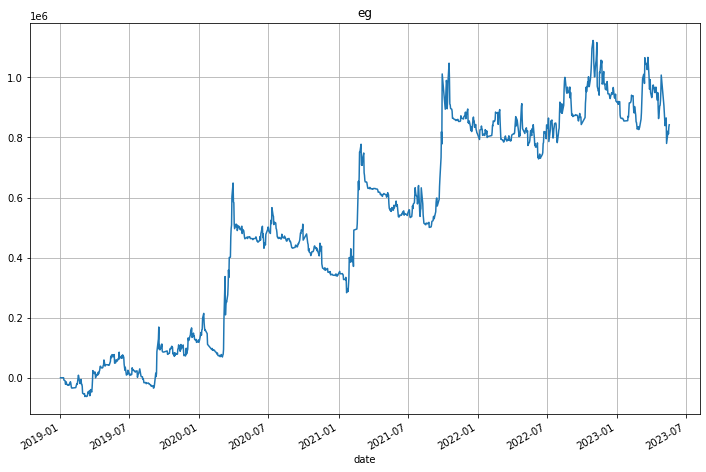

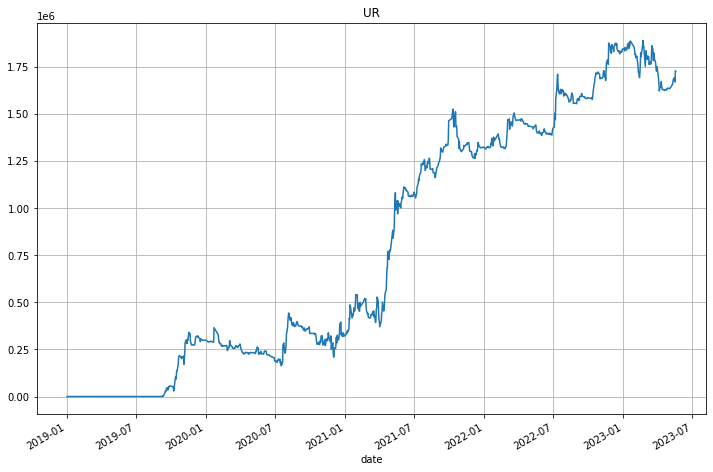

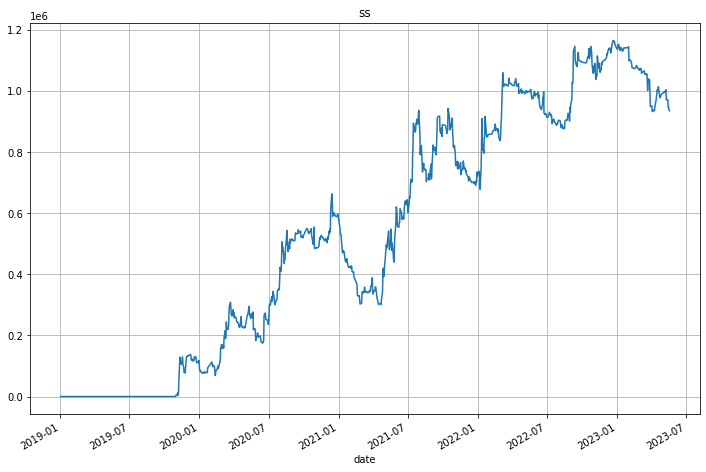

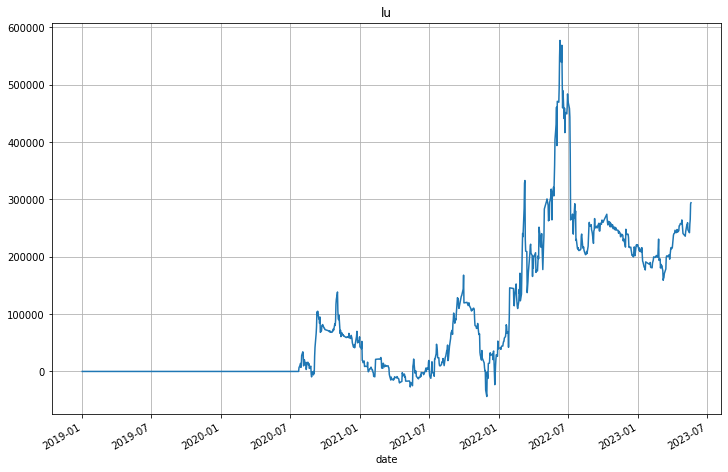

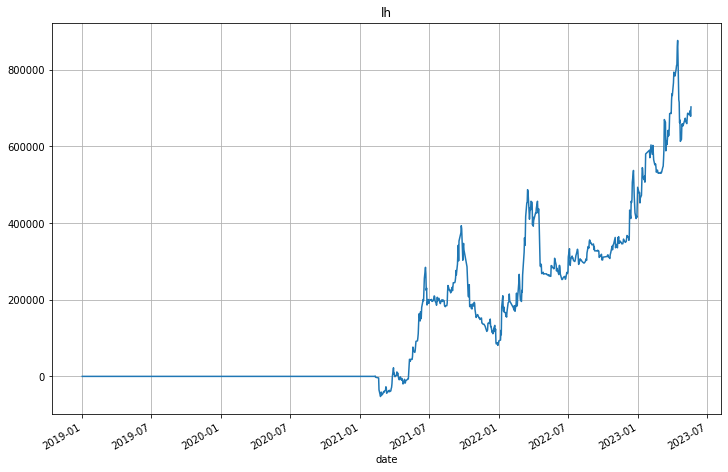

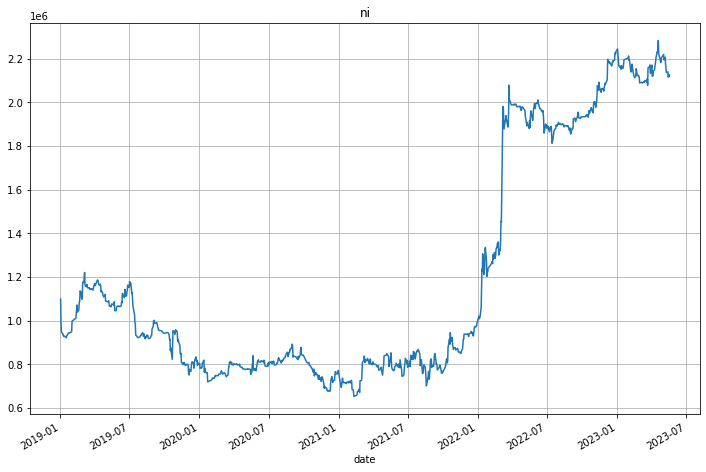

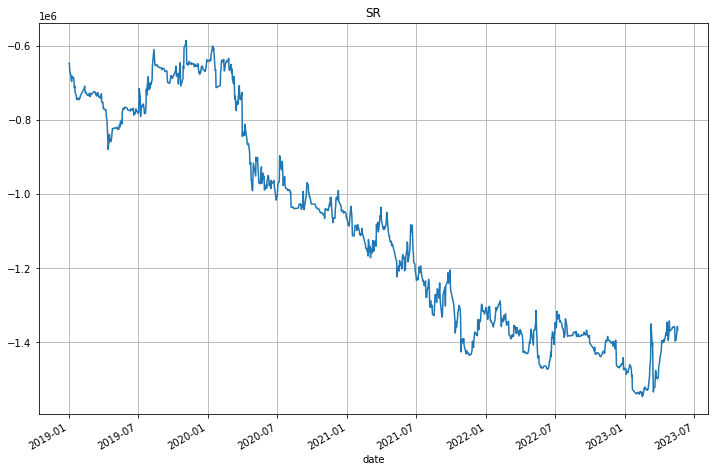

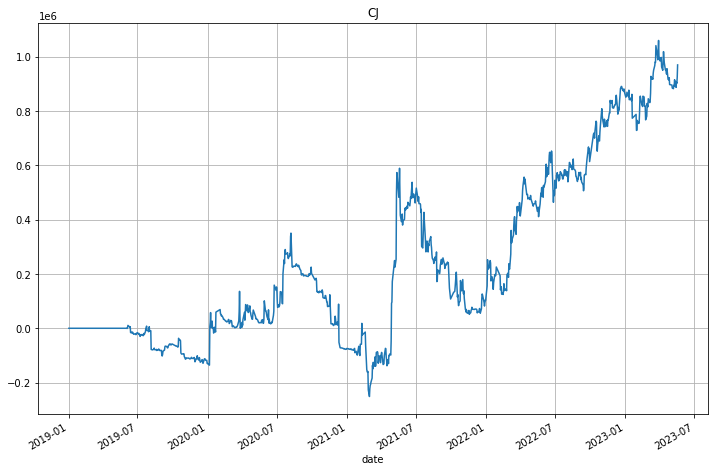

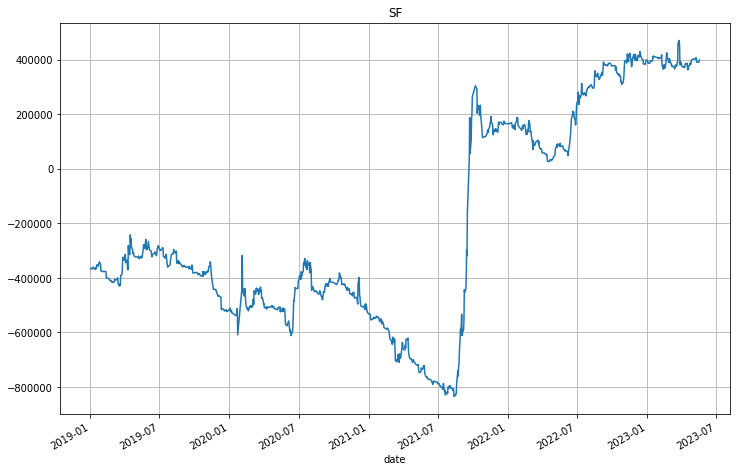

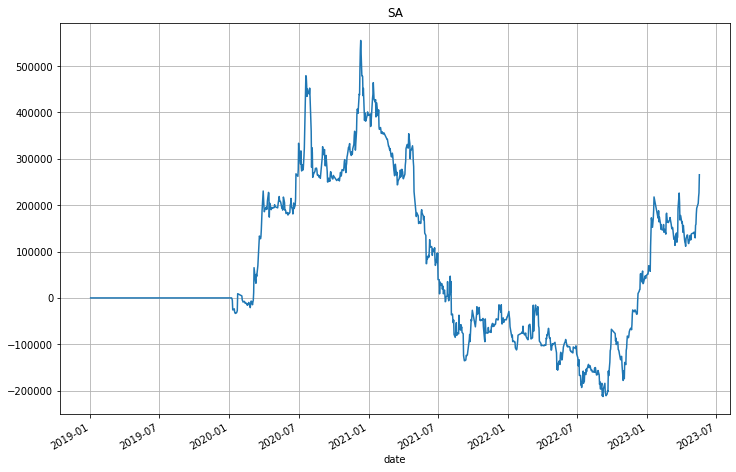

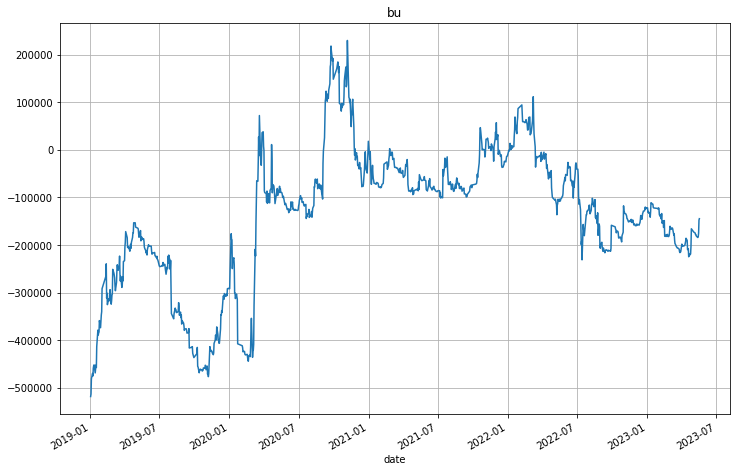

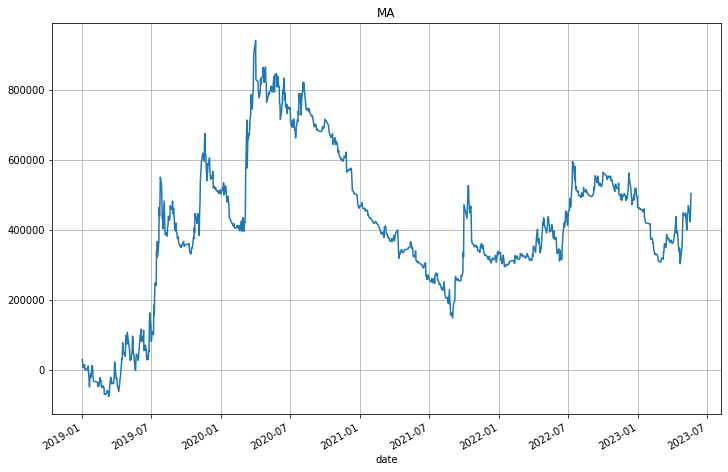

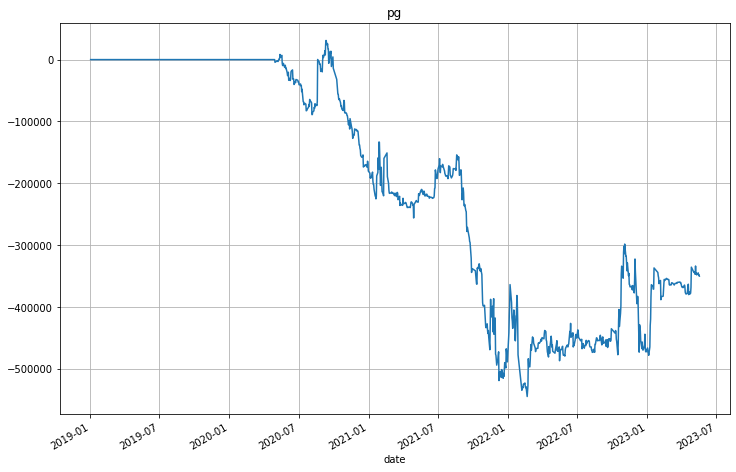

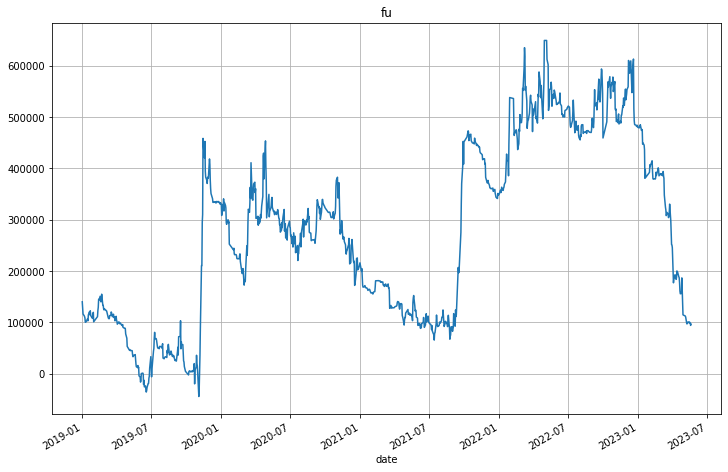

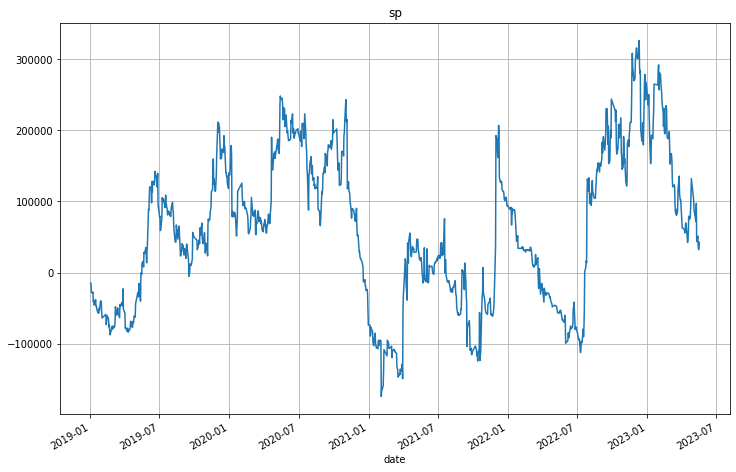

In [12]:
#pnl_stats = bt_empirics[run_key].calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])

#pnl_stats['asset_sharpe_stats']

for asset in port_stats['asset_cumpnl'].columns:
    port_stats['asset_cumpnl'][asset]['2019-01-01':].plot(title=asset)
    plt.grid()
    plt.show()